In [182]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import scipy.stats
import corner
import time

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [2]:
#limits 
b_min, b_max = 0, 50
A_min, A_max = 0, 50
t0_min, t0_max = 0, 100
alpha_min, alpha_max = np.exp(-5), np.exp(5)

### functions

In [126]:
def burst_model(theta, t):
    b, A, t0, alpha = theta
    return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))

In [127]:
def log_likelihood(theta, x, y, sigma, model = burst_model):
    y_model = model(theta, x)
    return - 0.5 * np.sum((y - y_model)**2 / sigma**2)

In [128]:
def log_prior(theta):
    b, A, t0, alpha = theta
    if b_min < b < b_max and A_min < A < A_max and t0_min < t0 < t0_max and alpha_min < alpha < alpha_max:
        return - np.log(alpha) #only this term is non constant
    return - np.inf

In [129]:
def log_posterior(theta, x, y, sigma, model = burst_model):
    return log_likelihood(theta, x, y, sigma, model) + log_prior(theta)

### main

In [130]:
file = '../solutions/transient.npy'
data = np.load(file)
t = data[:,0]
flux = data[:,1]
sigma_flux = data[:,2]

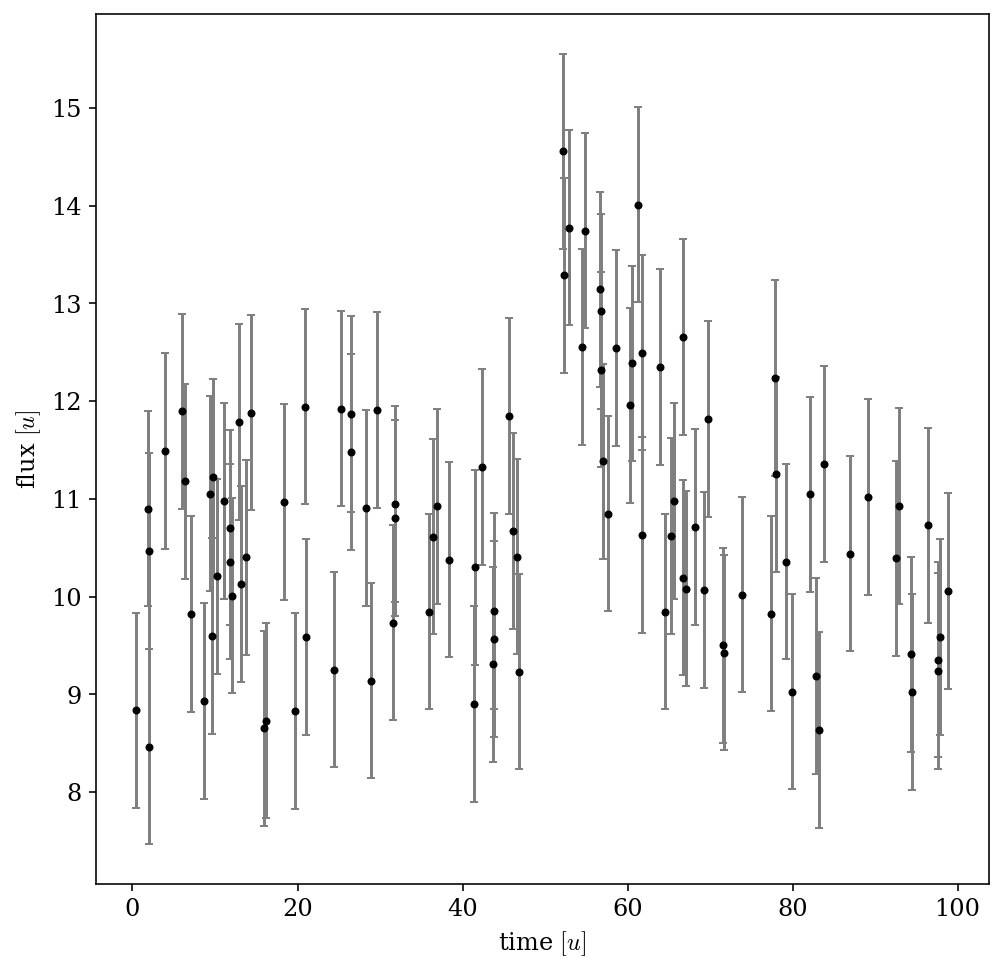

In [131]:
plt.errorbar(t, flux, yerr = sigma_flux, fmt ='.k', ecolor = 'gray', capsize = 2)
plt.xlabel(r'time $[u]$')
plt.ylabel(r'flux $[u]$')
plt.show()

### emcee

In [132]:
ndim = 4
nwalkers = 25
nsteps = int(1e4)

#initial guess

theta_guess = np.array([10, 5, 50, 0.1]) + np.random.rand(nwalkers, ndim) 

In [133]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[t, flux, sigma_flux, burst_model])
delta_t = time.time() #check how long it takes
sampler.run_mcmc(theta_guess, nsteps)
print('Computation completed in %.1f s' % (time.time() - delta_t))

Computation completed in 20.8 s


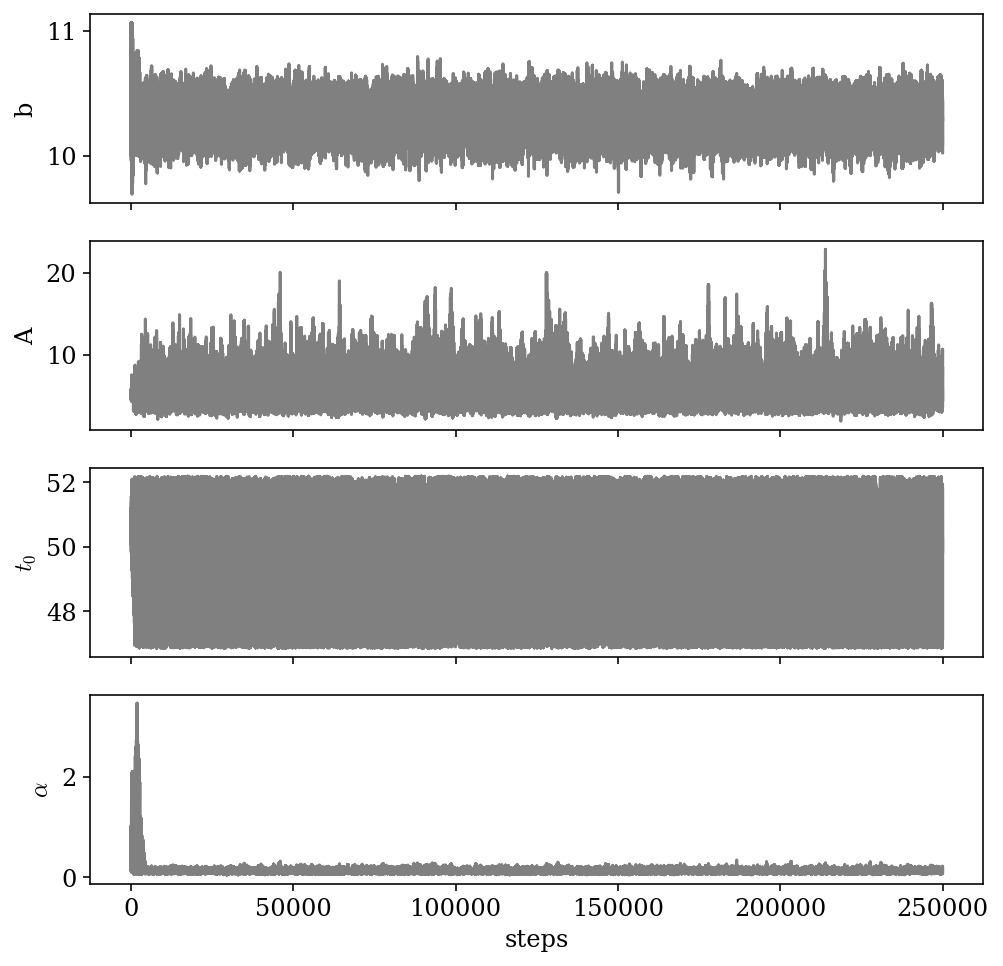

In [135]:
#chains
samples = sampler.get_chain(flat = True)

fig, axes = plt.subplots(ndim, sharex = True)
label = ['b', 'A', r'$t_0$', r'$\alpha$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], c = 'gray')
    ax.set_ylabel(label[i])
plt.xlabel('steps') 
plt.show()

In [147]:
#burn and thin the chain
corr_time = sampler.get_autocorr_time()
final_samples = sampler.get_chain(thin = int(max(corr_time)), discard = 4 * int(max(corr_time)), flat = True)

In [148]:
final_samples.shape

(2925, 4)

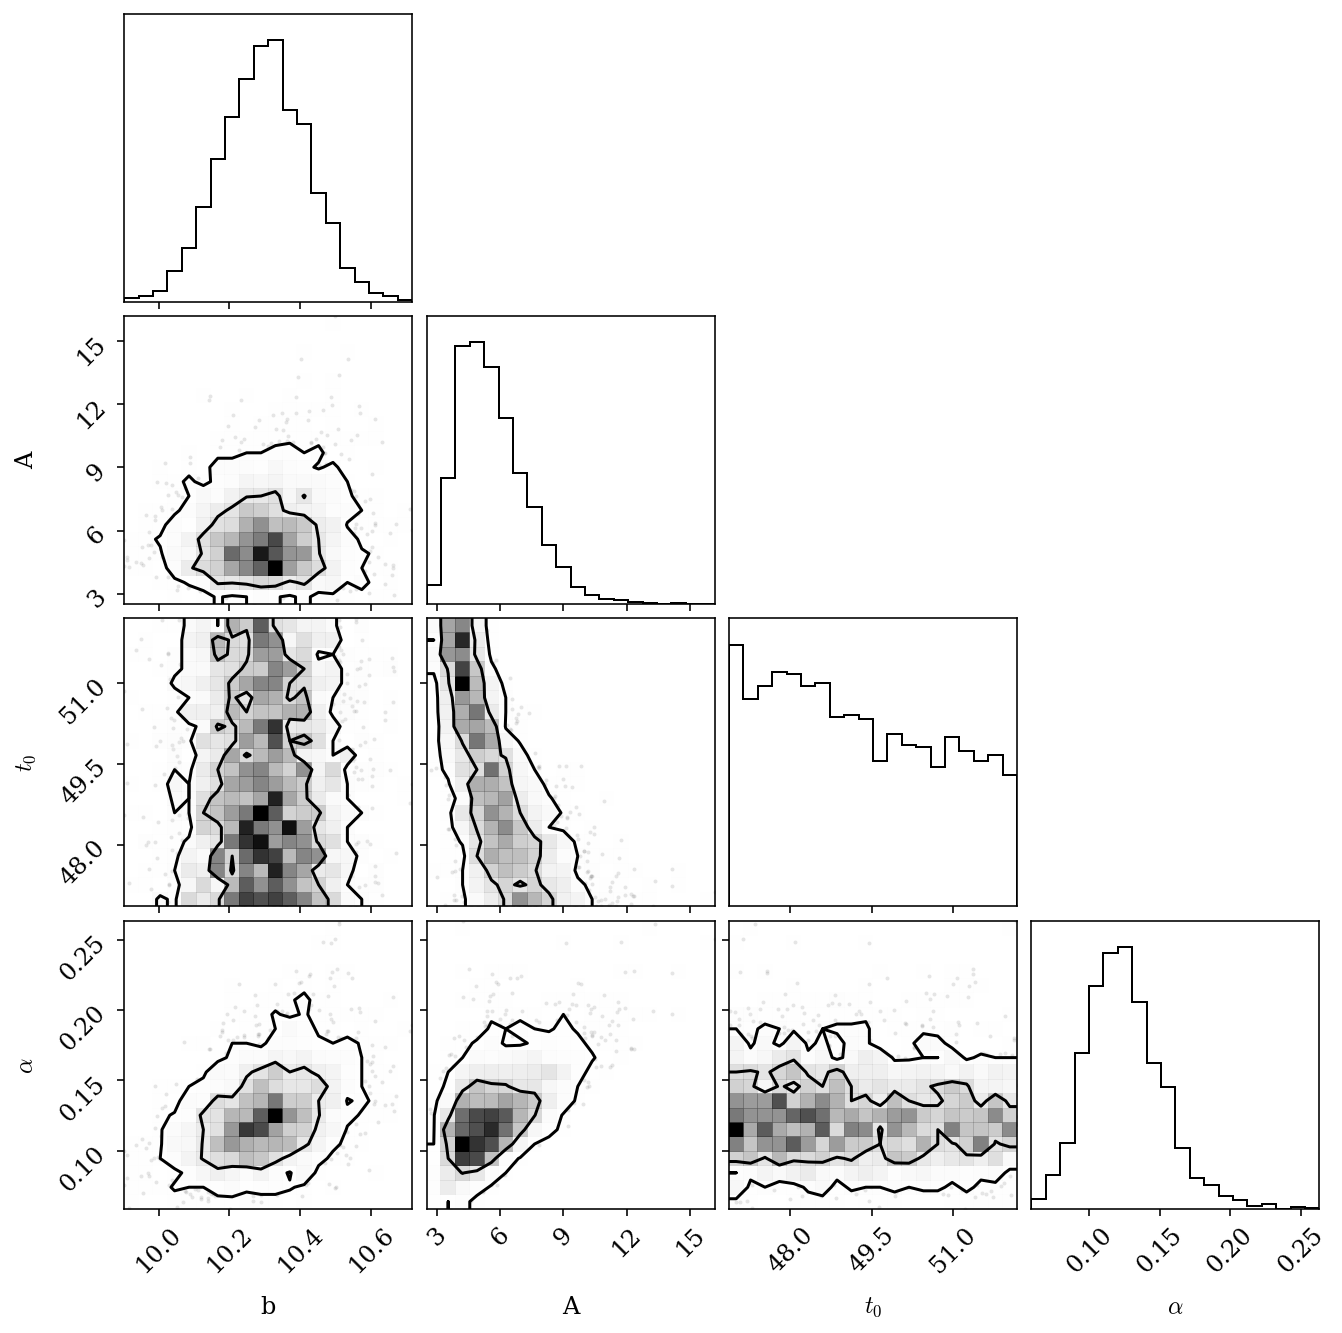

In [143]:
#corner plot
fig = corner.corner(
    final_samples, labels=label, levels=[0.68,0.95]
);

In [152]:
# 100 random samples
N_rand = 100
mask = np.random.choice(len(final_samples), size = N_rand)
choices = final_samples[mask]
grid = np.linspace(min(t), max(t), 100)

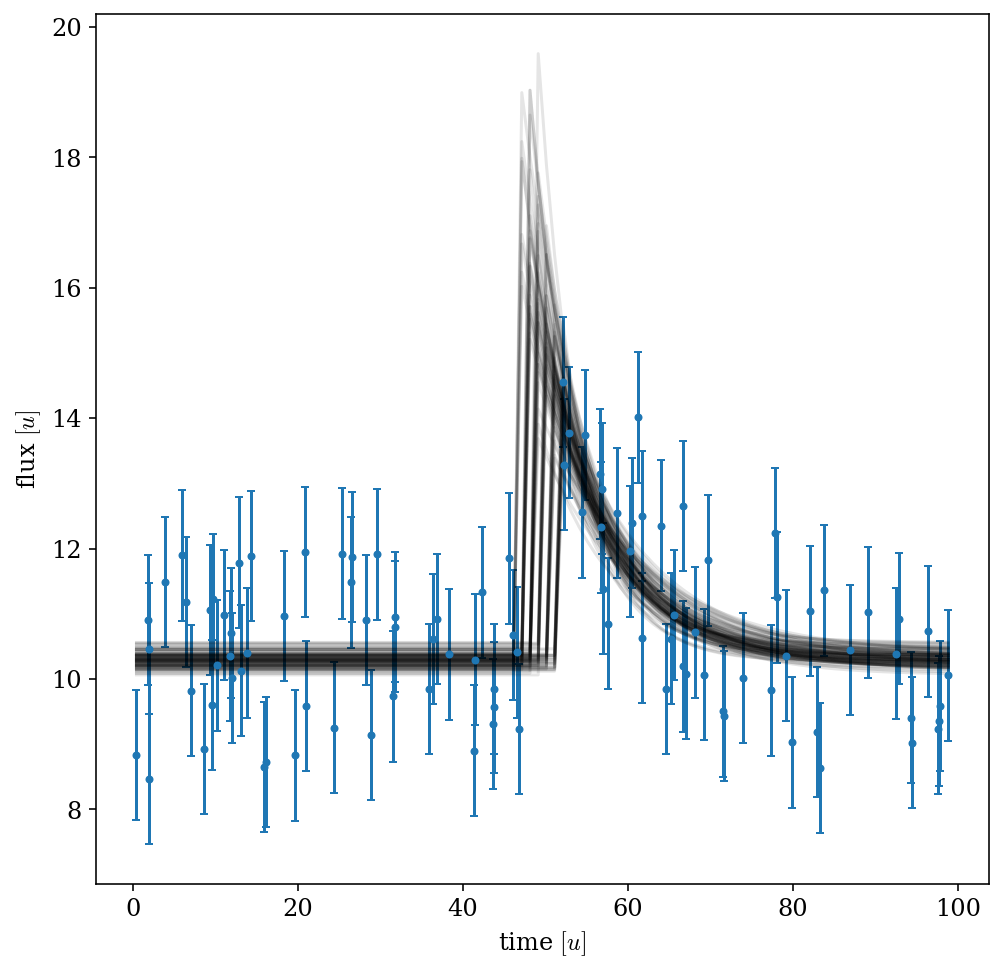

In [160]:
#plot
plt.figure()
plt.errorbar(t, flux, yerr = sigma_flux, fmt ='.', capsize = 2)

for choice in choices:
    plt.plot(grid, burst_model(choice, grid), c='k', alpha = .1)

plt.xlabel(r'time $[u]$')
plt.ylabel(r'flux $[u]$')
plt.show()

In [181]:
#median and 90% credible region
for i in range(ndim):
    stats = np.percentile(final_samples[:, i], [50, 5, 95])
    print(label[i] + ' = %.2f + %.2f - %.2f' % (stats[0], stats[0] - stats[1], stats[2] - stats[0]))

b = 10.30 + 0.20 - 0.20
A = 5.41 + 1.82 - 3.36
$t_0$ = 49.07 + 2.02 - 2.75
$\alpha$ = 0.12 + 0.04 - 0.05
